<a href="https://colab.research.google.com/github/SowjanyaKiran/Convolutional_Neural_Network_projects/blob/main/CNN_TRAFFIC_SIGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Installing the required libraries
!pip install kagglehub

In [3]:
#Downloading the data
import kagglehub
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print('Path to dataset files :', path)

Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Path to dataset files : /kaggle/input/gtsrb-german-traffic-sign


In [5]:
#Step 1 : Importing important libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [6]:
#Step 2 : Define the dataset
DATA_DIR = '/kaggle/input/gtsrb-german-traffic-sign'
train_path = os.path.join(DATA_DIR, 'Train')
test_path = os.path.join(DATA_DIR, 'Test')

In [7]:
#Specifying the parameters
BATCH_SIZE = 32
IMG_SIZE = (64, 64)

In [8]:
# Step 3 : Data Generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)


val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


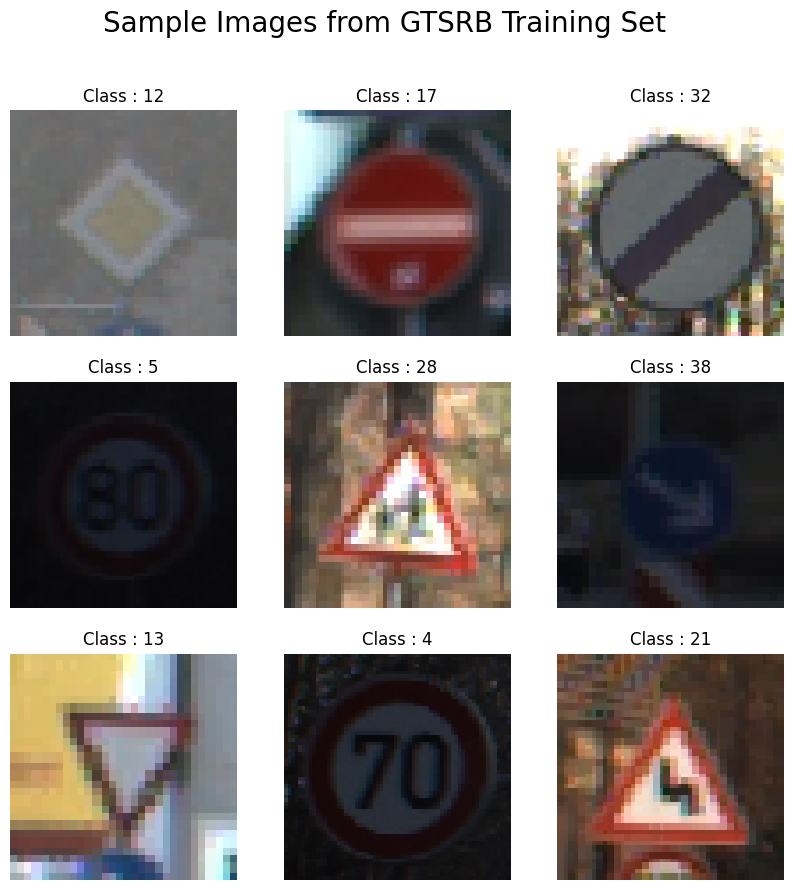

In [12]:
# Step 4 : Show sample Images
images, labels = next(train_generator)
plt.figure(figsize = (10, 10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.title(f"Class : {list(train_generator.class_indices.keys())[labels[i].argmax()]}")
  plt.axis('off')
plt.suptitle("Sample Images from GTSRB Training Set", fontsize = 20)
plt.show()

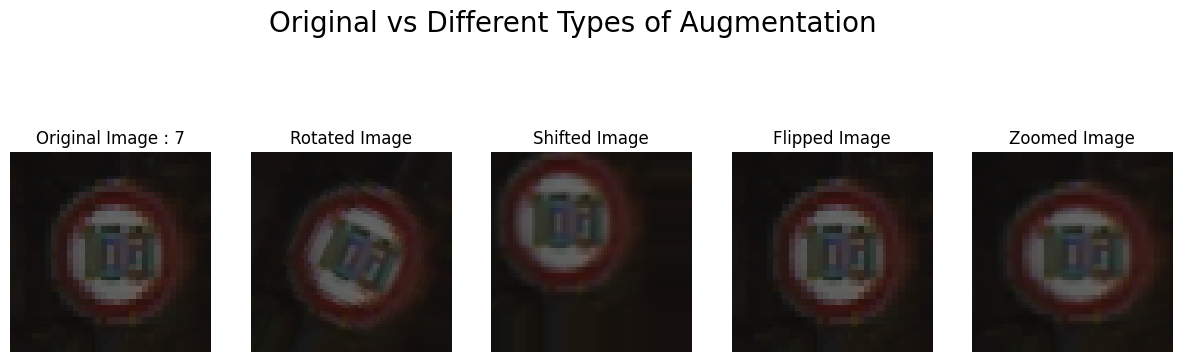

In [13]:
# Step 5 : Human-Friendly Augmentation
from tensorflow.keras.preprocessing.image import array_to_img

# Pick One Image
orig_images, orig_labels = next(train_generator)
image_to_augment = orig_images[0]
label_index = orig_labels[0].argmax()
label_name = list(train_generator.class_indices.keys())[label_index]

plt.figure(figsize = (15, 5))

# Original
plt.subplot(1, 5, 1)
plt.imshow(image_to_augment)
plt.title(f"Original Image : {label_name}")
plt.axis('off')

# Rotation
rot_datagen = ImageDataGenerator(rotation_range = 30)
rot_img = next(rot_datagen.flow(np.expand_dims(image_to_augment, 0)))[0]
plt.subplot(1, 5, 2)
plt.imshow(rot_img)
plt.title("Rotated Image")
plt.axis('off')

# Shift
shift_datagen = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2)
shift_img = next(shift_datagen.flow(np.expand_dims(image_to_augment, 0)))[0]
plt.subplot(1, 5, 3)
plt.imshow(shift_img)
plt.title("Shifted Image")
plt.axis('off')

# Flipped
flip_datagen = ImageDataGenerator(horizontal_flip =True)
flip_img = next(flip_datagen.flow(np.expand_dims(image_to_augment, 0)))[0]
plt.subplot(1, 5, 4)
plt.imshow(flip_img)
plt.title("Flipped Image")
plt.axis('off')

# Zoomed
zoom_datagen = ImageDataGenerator(zoom_range = 0.3)
zoom_img = next(zoom_datagen.flow(np.expand_dims(image_to_augment, 0)))[0]
plt.subplot(1, 5, 5)
plt.imshow(zoom_img)
plt.title("Zoomed Image")
plt.axis('off')

plt.suptitle("Original vs Different Types of Augmentation", fontsize = 20)
plt.show()

In [14]:
# Step 6 : CNN Model Builder
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
def build_cnn(num_hidden_layers = 1, neurons = 128, input_shape = (64, 64, 3), num_classes = 43):
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
  model.add(layers.MaxPooling2D(2, 2))

  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D(2, 2))

  model.add(layers.Flatten())

  for _ in range(num_hidden_layers):
    model.add(layers.Dense(neurons, activation = 'relu'))
    model.add(layers.Dropout(0.3))

  model.add(layers.Dense(num_classes, activation = 'softmax'))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [15]:
# Step 7 : Train Different Models (Faster)
configs = [
    {"layers" : 1, "neurons" : 64, "patience" : 2},
    {"layers" : 2, "neurons" : 128, "patience" : 2},
    {"layers" : 3, "neurons" : 256, "patience" : 2},
]
results = []

for cfg in configs:
  print(f"\nTraining model with {cfg['layers']} hidden layers, {cfg['neurons']} neurons, patience = {cfg['patience']}")
  model = build_cnn(num_hidden_layers = cfg['layers'], neurons = cfg['neurons'],
                    input_shape = (64, 64, 3), num_classes = len(train_generator.class_indices))

  early_stop = EarlyStopping(monitor = 'val_loss',
                             patience = cfg['patience'],
                             restore_best_weights = True)

  history = model.fit(train_generator,
                      validation_data = val_generator,
                      epochs = 5, # Reduced for faster demo
                      callbacks = [early_stop],
                       verbose = 1)

  val_acc = max(history.history['val_accuracy'])
  results.append({"layers" : cfg['layers'], "neurons" : cfg['neurons'],
                  "patience" : cfg['patience'], "val_acc" : val_acc})
  print(results)


Training model with 1 hidden layers, 64 neurons, patience = 2
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 268s 271ms/step - accuracy: 0.3426 - loss: 2.4451 - val_accuracy: 0.7540 - val_loss: 0.8562
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 198s 202ms/step - accuracy: 0.7064 - loss: 0.8907 - val_accuracy: 0.8578 - val_loss: 0.5383
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 191s 195ms/step - accuracy: 0.7722 - loss: 0.6741 - val_accuracy: 0.8677 - val_loss: 0.4944
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 196s 199ms/step - accuracy: 0.7997 - loss: 0.5841 - val_accuracy: 0.8818 - val_loss: 0.4547
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 191s 195ms/step - accuracy: 0.8197 - loss: 0.5178 - val_accuracy: 0.8725 - val_loss: 0.5015
[{'layers': 1, 'neurons': 64, 'patience': 2, 'val_acc': 0.8817752599716187}]

Training model with 2 hidden layers, 128 neurons, patience = 2
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 204s 206ms/step - accuracy: 0.3658 - loss: 2.2632 - val_accuracy: 0.8127 - val_loss: 0.6395
Epoch 2/5


In [16]:
# Final Results
results_df = pd.DataFrame(results)
print('\nComparison of different models :\n', results_df)


Comparison of different models :
    layers  neurons  patience   val_acc
0       1       64         2  0.881775
1       2      128         2  0.924882
2       3      256         2  0.920928


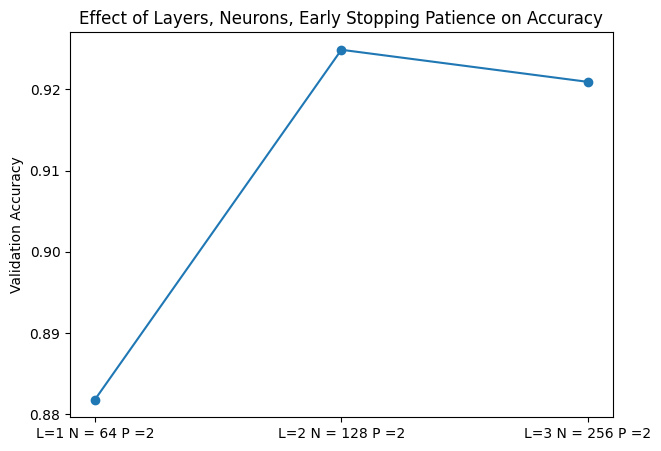

In [17]:
# Final Plot
plt.figure(figsize = (7, 5))
plt.plot(results_df['val_acc'], marker = 'o')
plt.xticks(range(len(results_df)), [f"L={r['layers']} N = {r['neurons']} P ={r['patience']}" for r in results])
plt.ylabel('Validation Accuracy')
plt.title('Effect of Layers, Neurons, Early Stopping Patience on Accuracy')
plt.show()

In [18]:
# Setting the random seed in tensorflow (Doubt)
tf.random.set_seed(42)